<a href="https://colab.research.google.com/github/hazmicokro/Breast-Cancer-Classification-using-Pyspark/blob/main/Breast%20Cancer%20Classification%20using%20Pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Author : Hazmi Cokro**

#[0] Install Pyspark

In [52]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
!pip install pyspark

     |████████████████████████████████| 204.2MB 69kB/s 
     |████████████████████████████████| 204kB 41.8MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612242 sha256=978fcad5b42d32d9baba36c0bf1ba22b2553011c12101c9baa955ed903db7021
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


#[1] Load Data

###[1.1] Download Dataset
UCI Dataset | Breast Cancer Wisconsin Original

In [3]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data

--2021-02-01 05:07:15--  https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19889 (19K) [application/x-httpd-php]
Saving to: ‘breast-cancer-wisconsin.data’

breast-cancer-wisco 100%[===================>]  19.42K  --.-KB/s    in 0.06s   

2021-02-01 05:07:15 (303 KB/s) - ‘breast-cancer-wisconsin.data’ saved [19889/19889]



In [4]:
import os
os.rename('breast-cancer-wisconsin.data','breast-cancer-wisconsin.csv') 

###[1.2] Build Pyspark dan Load Data
UCI Dataset | Breast Cancer Wisconsin Original

In [5]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, SQLContext

spark = SparkSession.builder.appName("Klasifikasi - Breast Cancer Wisconsin").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=Klasifikasi - Breast Cancer Wisconsin>

**Load Dataset (Spark.Read)**

In [32]:
df_csv = spark.read.format("csv").option("header", "true").load("breast-cancer-wisconsin.csv").toDF(
              "ID", "ClumpThickness","UnifromityCellSize","UniformityCellShape","Adhesion",
                "EpithelialCellSize","BareNuclei","BlandChromatin","NormalNuclei", "Class")

df_csv.show()

+-------+--------------+------------------+-------------------+--------+------------------+----------+--------------+------------+-------+-----+
|     ID|ClumpThickness|UnifromityCellSize|UniformityCellShape|Adhesion|EpithelialCellSize|BareNuclei|BlandChromatin|NormalNuclei|Mitoses|Class|
+-------+--------------+------------------+-------------------+--------+------------------+----------+--------------+------------+-------+-----+
|1000025|             5|                 1|                  1|       1|                 2|         1|             3|           1|      1|    2|
|1002945|             5|                 4|                  4|       5|                 7|        10|             3|           2|      1|    2|
|1015425|             3|                 1|                  1|       1|                 2|         2|             3|           1|      1|    2|
|1016277|             6|                 8|                  8|       1|                 3|         4|             3|           7|

#[2] Preprocessing Dataset
Drop NA | Labeling | Standarisasi 

###[2.1] Check dan Drop NA / Null
Drop NA Value

**Mengecek Tipe Data tiap Kolom**

In [33]:
df_csv.printSchema()

root
 |-- ID: string (nullable = true)
 |-- ClumpThickness: string (nullable = true)
 |-- UnifromityCellSize: string (nullable = true)
 |-- UniformityCellShape: string (nullable = true)
 |-- Adhesion: string (nullable = true)
 |-- EpithelialCellSize: string (nullable = true)
 |-- BareNuclei: string (nullable = true)
 |-- BlandChromatin: string (nullable = true)
 |-- NormalNuclei: string (nullable = true)
 |-- Mitoses: string (nullable = true)
 |-- Class: string (nullable = true)



In [34]:
df_csv.na.drop()

DataFrame[ID: string, ClumpThickness: string, UnifromityCellSize: string, UniformityCellShape: string, Adhesion: string, EpithelialCellSize: string, BareNuclei: string, BlandChromatin: string, NormalNuclei: string, Mitoses: string, Class: string]

###[2.2] Labeling
2 Label | B = 0 | Malignant = 1

In [35]:
from pyspark.sql.functions import col, when 

# 4 = M, 2 = B
df_csv = df_csv.withColumn("Class",when(col("Class") == 4, "M").when(col("Class") == 2, "B").otherwise(0))
df_csv.show()

+-------+--------------+------------------+-------------------+--------+------------------+----------+--------------+------------+-------+-----+
|     ID|ClumpThickness|UnifromityCellSize|UniformityCellShape|Adhesion|EpithelialCellSize|BareNuclei|BlandChromatin|NormalNuclei|Mitoses|Class|
+-------+--------------+------------------+-------------------+--------+------------------+----------+--------------+------------+-------+-----+
|1000025|             5|                 1|                  1|       1|                 2|         1|             3|           1|      1|    B|
|1002945|             5|                 4|                  4|       5|                 7|        10|             3|           2|      1|    B|
|1015425|             3|                 1|                  1|       1|                 2|         2|             3|           1|      1|    B|
|1016277|             6|                 8|                  8|       1|                 3|         4|             3|           7|

In [36]:
total_B = df_csv.filter(df_csv['Class']=='B').select('Class').count()
total_M = df_csv.filter(df_csv['Class']=='M').select('Class').count()
print("Jumlah Total Benign : ",total_B) #Unbalaced dataset
print("Jumlah Total Malignant : ", total_M) #Finding exact number's of each classes

Jumlah Total Benign :  458
Jumlah Total Malignant :  241


In [37]:
from pyspark.ml.feature import StringIndexer

# Konversi Class menjadi biner 0 (B) dan 1 (M)
indexer = StringIndexer(inputCol="Class", outputCol="label").fit(df_csv)
df_csv = indexer.transform(df_csv)
df_csv = df_csv.drop('Class')
df_csv.show(5)

+-------+--------------+------------------+-------------------+--------+------------------+----------+--------------+------------+-------+-----+
|     ID|ClumpThickness|UnifromityCellSize|UniformityCellShape|Adhesion|EpithelialCellSize|BareNuclei|BlandChromatin|NormalNuclei|Mitoses|label|
+-------+--------------+------------------+-------------------+--------+------------------+----------+--------------+------------+-------+-----+
|1000025|             5|                 1|                  1|       1|                 2|         1|             3|           1|      1|  0.0|
|1002945|             5|                 4|                  4|       5|                 7|        10|             3|           2|      1|  0.0|
|1015425|             3|                 1|                  1|       1|                 2|         2|             3|           1|      1|  0.0|
|1016277|             6|                 8|                  8|       1|                 3|         4|             3|           7|

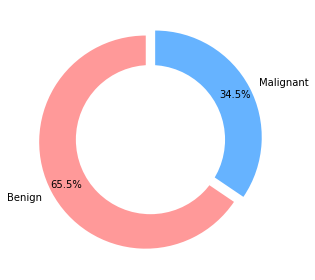

In [38]:
import matplotlib.pyplot as plt

# Pie Chart Label
labels = ['Benign', 'Malignant']
sizes = [total_B, total_M]
colors = ['#ff9999','#66b3ff']
explode = (0.05,0.05)
 
# Pie Chart Plot
plt.pie(sizes, colors = colors, labels=labels, autopct='%.1f%%', startangle=90, pctdistance=0.85, explode = explode)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.tight_layout()
plt.show()

###[2.3] Merubah Tipe Data
Menjadi Float | Kecuali Label Menjadi Integer

**Mengubah Tipe data semua fitur menjadi float dan Label menjadi Integer**

In [39]:
from pyspark.sql.types import * 
def Casting(columns,df):
    for i in columns:
        df = df.withColumn(i, df[i].cast(FloatType()))
    return df

df_csv = Casting(df_csv.columns,df_csv) 
df_csv = df_csv.withColumn("label",df_csv["label"].cast(IntegerType())) 

In [40]:
df_csv.printSchema() 

root
 |-- ID: float (nullable = true)
 |-- ClumpThickness: float (nullable = true)
 |-- UnifromityCellSize: float (nullable = true)
 |-- UniformityCellShape: float (nullable = true)
 |-- Adhesion: float (nullable = true)
 |-- EpithelialCellSize: float (nullable = true)
 |-- BareNuclei: float (nullable = true)
 |-- BlandChromatin: float (nullable = true)
 |-- NormalNuclei: float (nullable = true)
 |-- Mitoses: float (nullable = true)
 |-- label: integer (nullable = true)



###[2.4] Standarisasi Data
VectorAssembler | StandarScaller

In [41]:
from pyspark.ml.feature import VectorAssembler
selected_features = df_csv.select(
                              "ClumpThickness","UnifromityCellSize","UniformityCellShape","Adhesion",
                              "EpithelialCellSize","BareNuclei","BlandChromatin","NormalNuclei")

assembler = VectorAssembler(inputCols=selected_features.columns,
                           outputCol='features',
                           handleInvalid='skip')
df_csv = assembler.transform(df_csv)
df_csv.show(5)

+---------+--------------+------------------+-------------------+--------+------------------+----------+--------------+------------+-------+-----+--------------------+
|       ID|ClumpThickness|UnifromityCellSize|UniformityCellShape|Adhesion|EpithelialCellSize|BareNuclei|BlandChromatin|NormalNuclei|Mitoses|label|            features|
+---------+--------------+------------------+-------------------+--------+------------------+----------+--------------+------------+-------+-----+--------------------+
|1000025.0|           5.0|               1.0|                1.0|     1.0|               2.0|       1.0|           3.0|         1.0|    1.0|    0|[5.0,1.0,1.0,1.0,...|
|1002945.0|           5.0|               4.0|                4.0|     5.0|               7.0|      10.0|           3.0|         2.0|    1.0|    0|[5.0,4.0,4.0,5.0,...|
|1015425.0|           3.0|               1.0|                1.0|     1.0|               2.0|       2.0|           3.0|         1.0|    1.0|    0|[3.0,1.0,1.0,1

In [42]:
from pyspark.ml.feature import StandardScaler
standardScaler = StandardScaler().setInputCol("features").setOutputCol("scaled_features")
df_csv = standardScaler.fit(df_csv).transform(df_csv)
df_csv.show(5)

+---------+--------------+------------------+-------------------+--------+------------------+----------+--------------+------------+-------+-----+--------------------+--------------------+
|       ID|ClumpThickness|UnifromityCellSize|UniformityCellShape|Adhesion|EpithelialCellSize|BareNuclei|BlandChromatin|NormalNuclei|Mitoses|label|            features|     scaled_features|
+---------+--------------+------------------+-------------------+--------+------------------+----------+--------------+------------+-------+-----+--------------------+--------------------+
|1000025.0|           5.0|               1.0|                1.0|     1.0|               2.0|       1.0|           3.0|         1.0|    1.0|    0|[5.0,1.0,1.0,1.0,...|[1.77257110220912...|
|1002945.0|           5.0|               4.0|                4.0|     5.0|               7.0|      10.0|           3.0|         2.0|    1.0|    0|[5.0,4.0,4.0,5.0,...|[1.77257110220912...|
|1015425.0|           3.0|               1.0|          

#[3] Classification
Split Data | Random Forest | Naive Bayes | Gradient Boosting Forest

###[3.1] Splitting Data
Menjadi Train 80% dan Test 20%

In [43]:
train_df, test_df = df_csv.select("label","scaled_features","ID").randomSplit([0.8,0.2], seed=140)

###[3.2] Naive Bayes Classication 
NBClassifier | (Versi Pyspark)

In [57]:
from pyspark.ml.classification import NaiveBayes

NB = NaiveBayes(featuresCol = 'scaled_features', labelCol = 'label')
NB_model = NB.fit(train_df)
predictionsNB = NB_model.transform(test_df)

In [60]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

NBpredictB = predictionsNB[predictionsNB.prediction==0].toPandas()
NBpredictM = predictionsNB[predictionsNB.prediction==1].toPandas()

result = pd.concat([NBpredictM,NBpredictB])
true_labels=(test_df.orderBy("ID").select("label")).toPandas()
predicted_labels=result.sort_values("ID")["prediction"]

print("-- Naive Bayes --")
print("------------------------------------------------------------------------")
print("Classification Report\n",classification_report(true_labels, predicted_labels))
print("------------------------------------------------------------------------")
print("Confusion matrix\n",confusion_matrix(true_labels,predicted_labels),"\n\n")
NBA=confusion_matrix(true_labels,predicted_labels)

-- Naive Bayes --
------------------------------------------------------------------------
Classification Report
               precision    recall  f1-score   support

           0       0.84      0.99      0.91        89
           1       0.97      0.65      0.78        48

    accuracy                           0.87       137
   macro avg       0.90      0.82      0.84       137
weighted avg       0.88      0.87      0.86       137

------------------------------------------------------------------------
Confusion matrix
 [[88  1]
 [17 31]] 




###[3.3]Gradient-Boosted Tree  Classication 
GBTClassifier | (Versi Pyspark)

In [61]:
from pyspark.ml.classification import GBTClassifier

GBT = GBTClassifier(featuresCol = 'scaled_features', labelCol = 'label',seed=140)
GBT_model = GBT.fit(train_df)
GBTpredictions = GBT_model.transform(test_df)

In [63]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

GBTpredictB = GBTpredictions[GBTpredictions.prediction==0].toPandas()
GBTpredictM = GBTpredictions[GBTpredictions.prediction==1].toPandas()

result = pd.concat([GBTpredictM,GBTpredictB])
true_labels=(test_df.orderBy("ID").select("label")).toPandas()
predicted_labels=result.sort_values("ID")["prediction"]

print("-- Gradient-Boosted Tree --")
print("------------------------------------------------------------------------")
print("Classification Report\n",classification_report(true_labels, predicted_labels))
print("------------------------------------------------------------------------")
print("Confusion matrix\n",confusion_matrix(true_labels,predicted_labels),"\n\n")
GBTA = confusion_matrix(true_labels,predicted_labels)

-- Gradient-Boosted Tree --
------------------------------------------------------------------------
Classification Report
               precision    recall  f1-score   support

           0       0.99      0.97      0.98        89
           1       0.94      0.98      0.96        48

    accuracy                           0.97       137
   macro avg       0.96      0.97      0.97       137
weighted avg       0.97      0.97      0.97       137

------------------------------------------------------------------------
Confusion matrix
 [[86  3]
 [ 1 47]] 




###[3.4] Random Forest Classication 
RFClassifier | (Versi Pyspark)

In [45]:
from pyspark.ml.classification import RandomForestClassifier

RFR = RandomForestClassifier(featuresCol = 'scaled_features', labelCol = 'label',seed=140)
RFR_model = RFR.fit(train_df)
predictions = RFR_model.transform(test_df)

In [51]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

RFpredictB = predictions[predictions.prediction==0].toPandas()
RFpredictM = predictions[predictions.prediction==1].toPandas()

result = pd.concat([RFpredictM,RFpredictB])
true_labels=(test_df.orderBy("ID").select("label")).toPandas()
predicted_labels=result.sort_values("ID")["prediction"]

print("-- Random Forest --")
print("------------------------------------------------------------------------")
print("Classification Report\n",classification_report(true_labels, predicted_labels))
print("------------------------------------------------------------------------")
print("Confusion matrix\n",confusion_matrix(true_labels,predicted_labels),"\n\n")
rfA=confusion_matrix(true_labels,predicted_labels)

-- Random Forest --
------------------------------------------------------------------------
Classification Report
               precision    recall  f1-score   support

           0       1.00      0.99      0.99        89
           1       0.98      1.00      0.99        48

    accuracy                           0.99       137
   macro avg       0.99      0.99      0.99       137
weighted avg       0.99      0.99      0.99       137

------------------------------------------------------------------------
Confusion matrix
 [[88  1]
 [ 0 48]] 




#[4] Evaluation
Evaluasi Model | RF | NB | GBT

In [72]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
NBevaluator = MulticlassClassificationEvaluator( labelCol="label", 
                                                                         predictionCol="prediction", metricName="accuracy")
NBaccuracy = NBevaluator.evaluate(predictionsNB)
print("Model accuracy: %.2f%% \n" % (NBaccuracy * 100))

Model accuracy: 86.86% 



In [73]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
GBTevaluator = MulticlassClassificationEvaluator( labelCol="label", 
                                                                         predictionCol="prediction", metricName="accuracy")
GBTaccuracy = GBTevaluator.evaluate(GBTpredictions)
print("Model accuracy: %.2f%% \n" % (GBTaccuracy * 100))

Model accuracy: 97.08% 



In [74]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
RFevaluator = MulticlassClassificationEvaluator( labelCol="label", 
                                                                         predictionCol="prediction", metricName="accuracy")
RFaccuracy = RFevaluator.evaluate(predictions)
print("Model accuracy: %.2f%% \n" % (RFaccuracy * 100))

Model accuracy: 99.27% 



In [77]:
data = {'Classification': ["Naive Bayes","Gradient-Boosting Tree ","Random Forest"], 'Accuracy %': [86.86,97.08, 99.27]}
df = pd.DataFrame(data=data)
df.head()

,Classification,Accuracy %
0,Naive Bayes,86.86
1,Gradient-Boosting Tree,97.08
2,Random Forest,99.27
